In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from sklearn.datasets import load_iris, fetch_olivetti_faces
from sklearn.decomposition import PCA, TruncatedSVD
from pandas.tools.plotting import scatter_matrix

# Always make it pretty.
plt.style.use('ggplot')

%matplotlib inline

Dimensionality Reduction - Morning Lecture
==========================================

**Recall:** The dimensionality of an object is the number of independent measurements that are needed to fully describe it.

### **Example:** A pendulum swinging in a plane.
    
![Plane Pendulum](img/pendulum.png)

Image Source: https://www.netnod.se/sites/default/files/PAF%2020151014-Netnod-NTP.pdf

Naively, to describe

  - The *position* of the pendulum, we need two measurements $x$, and $y$.
  - The *velocity* of the pendulum, we need two measurements $\frac{d x}{dt}$, and $\frac{d y}{dt}$
  
Given these, *Newton's Laws of Motion* describe the motion of the pendulum as

$$ T cos(\theta) - mg = m \frac{d^2 y}{d t^2} $$
$$ T sin(\theta) = m \frac{d^2 x}{d t^2} $$

where $\theta = arctan \left( \frac{y}{x} \right)$ is introduced into the equations for convenience.

So, viewed from this perspective, the physics of the pendulum is described as a *four dimensional object*.

**But there is another way**.

Geometrically, the position of the pendulum is restricted to a circle, and it's velocity must be tangent to this circle.  So there is a more efficient description the pendulum system

  - The angular measure $\theta$ gives the position on the circle.
  - The angular velocity $\frac{d \theta}{dt}$ (a vector tangent to the circle) gives the velocity of the pendulum.
  
In these terms, the motion of the pendulum is described by the *single* equation

$$ \frac{d^2 \theta}{d t^2} - g sin(\theta) = 0 $$

We have *reduced the dimensionality of the problem* from four to two, and in the process discovered a simpler description of the *same thing*.

### Reason to Reduce Dimensions #1:

To experess a problem or describe an object in a more natural way.

### Example: Scatterplots in Cubes.

The **curse of dimensionality** is an unintuitive geometric phenomena in high dimensional spaces.  Roughly it says

> The number of points needed to evenly sample an N-dimensional cube grows exponentially with N.

It sometimes helpful to say this in reverse

> If you have a fixed number of points of increasing dimension (i.e. you describe the points with more and more measurements), the average distance between the points grows exponentially.

To illustrate, let's sample a fixed number of points from unit hypercubes of increasing dimension.

In [2]:
N_points = 1000
dimensions = range(1, 10)

samples = {}
for dim in dimensions:
    samples[dim] = np.random.uniform(size=N_points*dim).reshape((N_points, dim))

For each of these samples, lets measure how much of the data lies inside a small cube of increasing size centered at a corner of the unit cube.

Like this for our two dimensional data:

In [3]:
def num_points_within(sample, x):
    """Count the number of points in sample within x of the origin in
    each direction.
    """
    within = sample <= x
    all_within = np.all(within, axis=1)
    return np.sum(all_within)

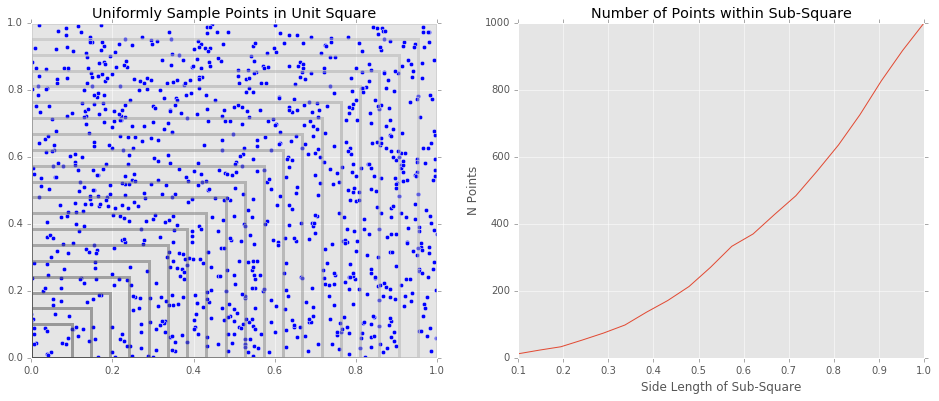

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

two_dim_data = samples[2]
ticks = np.linspace(0.1, 1, num=20)

ax = axs[0]
ax.scatter(two_dim_data[:, 0], two_dim_data[:, 1])
for edge_len in reversed(ticks):
    ax.add_patch(patches.Rectangle((0, 0), edge_len, edge_len, 
                                   color=cm.gray(0.25 + 0.5*edge_len), 
                                   linewidth=3, fill=False, alpha=0.5))
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_title("Uniformly Sample Points in Unit Square")

ax = axs[1]
density = [num_points_within(two_dim_data, edge_len) for edge_len in ticks]
ax.plot(ticks, density)
ax.set_title("Number of Points within Sub-Square")
ax.set_xlabel("Side Length of Sub-Square")
ax.set_ylabel("N Points")

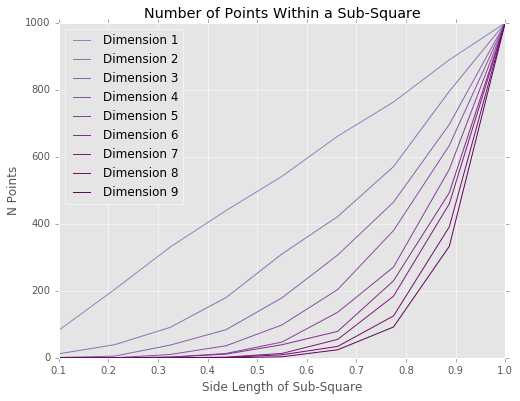

In [5]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ticks = np.linspace(0.1, 1, num=9)

for dim, sample in samples.iteritems():
    density = [num_points_within(sample, edge_len) for edge_len in ticks]
    ax.plot(ticks, density, label="Dimension {}".format(dim), 
            color=cm.BuPu(0.5 + dim/20.0))
    
ax.legend(loc="upper left")
ax.set_title("Number of Points Within a Sub-Square")
ax.set_xlabel("Side Length of Sub-Square")
ax.set_ylabel("N Points")

In larger dimensions less and less of that data is *near* the fixed corner of the cube.

*Revisit Jack's Example*

https://github.com/zipfian/DSI_Lectures/blob/master/clustering/jfomhover/curse_of_dimensionality.ipynb

For algorithms that make predictions at $x$ by looking for training samples that are *near* $x$, we need an increasingly vast amount of data to construct accurate models.

**Discussion:** What algorithms we have studied use only points *near* $x$ to make predictions or inferences about $x$.  Which do not have this property?

### Reason to Reduce Dimensions #2:

To combat the curse of dimensionality.

### Example: Visualization of Data

In Fischer's classic iris dataset, we describe flowers by four measurements, so it is a four dimensional representation of the flowers.

![Iris Measurements](img/iris-measurements.png)

In [6]:
iris = load_iris()
iris_data = pd.DataFrame(iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
iris_type = iris.target
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Data of dimension larger than *two* leads to challenges for visualization.  In dimension three we can draw some plots, but they are hard to use.  In dimension four, we need **coping strategies**.

**One option** is to plot each feature against each other feature in a scatter plot.

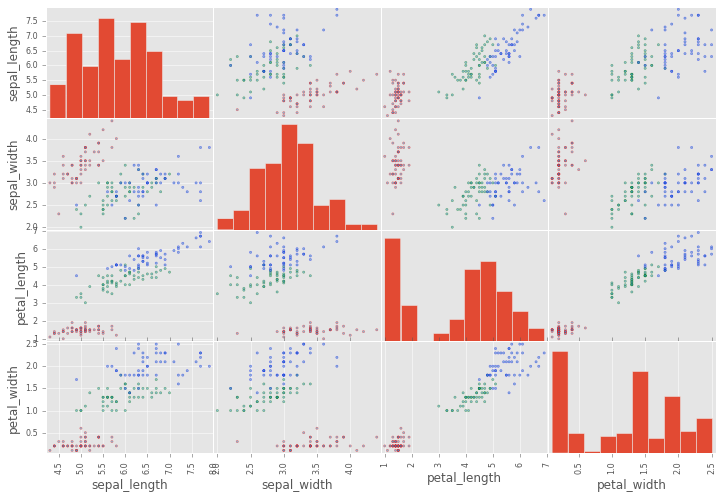

In [7]:
_ = scatter_matrix(iris_data, 
                   color=np.array(["red", "green", "blue"])[iris_type], 
                   figsize=(12, 8))

**Discussion:** How can we construct *one* scatterplot of the four dimensional data that *best* represents it.

### Reason to Reduce Dimensions #3:

To compensate for our inability to visualize high dimensional situations.

### Principal Component Analysis

Let's think of our data as a point cloud in $p$-dimensional space, and ask the following question:

**Fundamental Question:** How can we find a 1-dimensional data set $X_1$ so that

  - Going from $X$ to $X_1$ is a very simple operation.
  - In some sense, $X_1$ is the *best* one dimensional reconstruction of $X$.

**Discussion:** Consider "Going from $X$ to $X_1$ is a very simple operation".  What are some good candidates for *simple operations*.  The following animation may be suggestive.

![Pca Animation](img/pca.gif)

Image source: http://stats.stackexchange.com/a/140579/74500

We look for a line so that the *projection* of $X$ onto that line

  - Results in points minimizing the total squared distance to $X$
  - Results in points with *maximum variance* as a 1-dimensional data set.

In [8]:
N_points = 75

In [9]:
def random_data_set(n=N_points):
    theta = np.random.uniform(low=0, high=2*3.14159)
    rotation = np.array([[np.cos(theta), np.sin(theta)], 
                         [-np.sin(theta), np.cos(theta)]])
    data = np.column_stack([np.random.normal(size=n), 2*np.random.normal(size=n)])
    rotated_data = np.dot(data, rotation)
    return rotated_data

In [10]:
def plot_1dim_pca(ax):
    """Make a plot of:
        - A point cloud rotated to an random angle (blue).
        - The principal component line through the orgin (green).
        - Plot the eigenvector representing the principal component (black).
        - The point cloud projected onto the principal component line (green).
    """
    X = random_data_set()
    pcd = PCA(1).fit(X)
    e = pcd.components_[0]
    # Plot the data set.
    ax.scatter(X[:, 0], X[:, 1])
    # Plot a line for the principal component.
    x = np.linspace(-10, 10, num=3)
    ax.plot(e[0]*x, e[1]*x, color='green', alpha=0.3, linestyle='-')
    # Plot the projections of the data points onto the line.
    X_proj = np.dot(X, e)
    X_reconst = np.array([t*e for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot an arrow for the first principal direction.
    ax.arrow(0, 0, e[0], e[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.set(adjustable='box-forced', aspect='equal')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

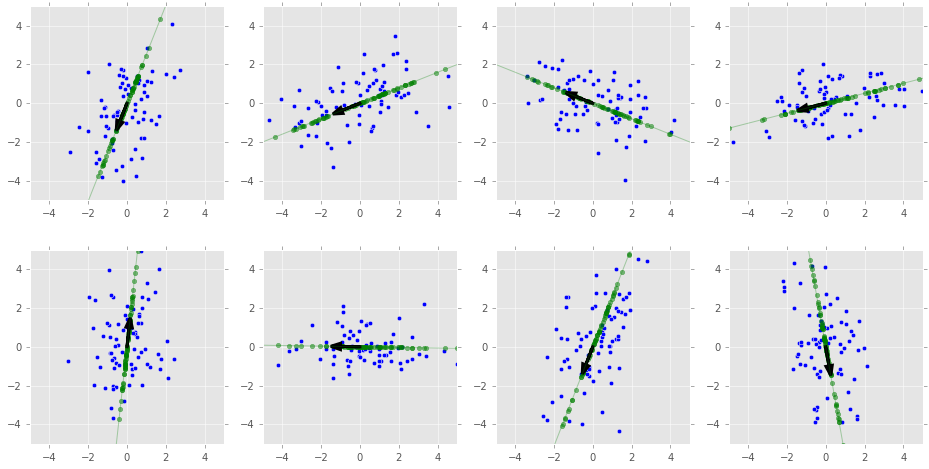

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax in axs.flatten():
    plot_1dim_pca(ax)

**In general** PCA applied to a dataset $X$ returns the best line, plane, 3-space, 4-space, ... so that when $X$ is projected into the subspace

  - The total squared distance from the original data to the projections in minimized.
  - The variance of the projected dataset is maximal.

The solution to this problem involves, somewhat surprisingly, the *eigenvalues* and *eigenvectors* of the covariance matrix $X^t X$ of $X$.

**Note:** X must be centered before computing the covariance in this manner.

## Intermission: Whiteboard Work

### Summary:

The Principal Components algorithm computes the *eigenvectors* and *eigenvalues* of the matrix $X^t X$.

Each eigenvector is called a *principal component* of $X$.

In [ ]:
def plot_2dim_pca(ax):
    """Make a plot of:
        - A point cloud rotated to an random angle (blue).
        - The principal component lines through the orgin (green).
        - The eigenvectors representing the principal components (black).
        - The point cloud projected onto the principal component lines (green).
    """
    X = random_data_set()
    pcd = PCA(2).fit(X)
    e_1 = pcd.components_[0]
    e_2 = pcd.components_[1]
    # Plot the data set.
    ax.scatter(X[:, 0], X[:, 1])
    # Plot a lines for the principal components.
    x = np.linspace(-10, 10, num=3)
    ax.plot(e_1[0]*x, e_1[1]*x, color='green', alpha=0.3, linestyle='-')
    ax.plot(e_2[0]*x, e_2[1]*x, color='green', alpha=0.3, linestyle='-')
    # Plot the projections of the data points onto the first line.
    X_proj = np.dot(X, e_1)
    X_reconst = np.array([t*e_1 for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot the projections of the data points onto the second line.
    X_proj = np.dot(X, e_2)
    X_reconst = np.array([t*e_2 for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot an arrow for the first principal direction.
    ax.arrow(0, 0, e_1[0], e_1[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.arrow(0, 0, e_2[0], e_2[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.set(adjustable='box-forced', aspect='equal')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

In [ ]:
fig, ax = plt.subplots(1, figsize=(6, 6))
plot_2dim_pca(ax)
ax.set_title("Principal Components of a 2-dim Point Cloud")

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax in axs.flatten():
    plot_2dim_pca(ax)

**In practice** sklearns `PCA` returns an object with a `components_` attribute.

  - The `components_` attribute is an orthogonal matrix contining (as rows) a basis for the k-dimensional subspace that results in the "best" projection.  Let's call this matrix $E$.
  - Taking the first $k$ rows of $E$ gives (a basis for) the "best" $k$ dimensional subspace.  We call this subset matrix $E_{1:k}$.
  - The matrix multilication $XE_{1:k}^t$ gives the *coefficients* of the "best" reconstruction of $X$ in the basis $E_k$.
  - The matrix multiplication $(X E_{1:k}^t) E_{1:k}$ gives the "best" reconstruction of $X$ as a $k$ dimensional object.
  
Each of the rows in $E$ is an *eigenvector* of the covarince matrix $X^t X$ ($X$ must be centered).

**Exercise:** Below we create a random 4-dimensional dataset $X$.  Create the "best" 2 dimensional reconstruction of $X$.

In [ ]:
X = np.random.uniform(size=100*4).reshape((100, 4))

Additionally, the `explained_variance_` attribute contains the variance of the *projected* dataset.

Each of the numbers in `explained_variance_` is an *eigenvalue* of the covariance matrix $X^t X$.

**Exercise:** Using the $X$ data above, what fraction of the varaince is explained by the first two principal components.

### Example: The Best Scatterplot of Iris

Let's construct a "best" scatterplot of the iris dataset using PCA to project

```
Four dimensional iris data => Best two dimensional plane
```

In terms of the above discussion we are plotting the *expression of $X$ in the principal componenet basis*.

$$ X E_2^t $$

In [ ]:
pcd = PCA(2).fit(iris_data.values)
iris_reduced = np.dot(iris_data.values, pcd.components_.T)

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(iris_reduced[:, 0], iris_reduced[:, 1], 
           color=np.array(["red", "green", "blue"])[iris_type])
ax.set_title("Scatterplot of Iris Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

### Example: Eigenfaces

As an example of *very* high dimensional data, we introduce the `faces` data set.

An extended version of this example is available in the sklearn docs here: http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html

In [ ]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=154)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

In [ ]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [ ]:
plot_gallery("Centered Olivetti faces", faces_centered[:n_components])

Each of these images is stored as a numpy array.

Each entry in the array measures *one* pixel intensity.

In [ ]:
first_face = faces_centered[0].reshape(image_shape)
print(first_face)
plt.imshow(first_face, cmap=cm.gray)

Don't believe me?

In [ ]:
first_face_ascii = np.array(['#', '.'])[(first_face >= 0).astype(int).flatten()].reshape(image_shape)
print '\n'.join([''.join(row) for row in first_face_ascii])

Each image is a $64 \times 64$ array, and so is represented as a $4096$ dimensional object.

**Discussion:** Do you really believe that faces are $4096$ dimensional objects?

Let's apply PCA to the faces dataset to lower the dimensionality.

In [ ]:
faces_pcd = PCA(100).fit(faces_centered)

The columns in the $E^t$ matrix (i.e. `faces_pcd.components_.T`) are called **eigenfaces**.

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ax, i in zip(axs.flatten(), range(6)):
    eigenface = faces_pcd.components_[i, :].reshape(image_shape)
    ax.imshow(eigenface, cmap=cm.gray)
    ax.set_title("{}'th Eigenface".format(i))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

**Question:** What facial features seem to be captured in the first few eigenfaces?  Why do you think this may be so?

In [ ]:
def reduce_face_data(n_dim):
    eigenvalues = faces_pcd.components_[:n_dim, :].T
    faces_reduced = np.dot(np.dot(faces_centered, eigenvalues), eigenvalues.T)
    return faces_reduced

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(13, 6))

for ax, dim in zip(axs.flatten(), [2, 4, 10, 25, 50, 100]):
    reduced_data = reduce_face_data(dim)
    first_face = reduced_data[0].reshape(image_shape)
    ax.imshow(first_face, cmap=cm.gray)
    ax.set_title("Face Reconstructed with {} Components".format(dim))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

**Discussion:** When applying PCA to reduce the dimensionality of a data set, we have to choose a *number of dimensions* to keep.  What kind of concerns should we consider when choosing this number?

## Singular Value Decomposition - Afternoon Lecture

**Opening Question:**: http://stats.stackexchange.com/questions/239518/logistic-regression-with-lasso-versus-pca

The PCA algorithm can be expressed pithily as the following matrix equation

$$ X^t X = E^t D E $$

where

  - $E$ is the matrix of eigenvectors (i.e. principal components).
  - $D$ is a *diagonal* matrix.  The diagonal entries are the eigenvalues.

There is a closely related matrix factorization, the SVD decomposition.

**Any** $n \times p$ matrix $X$ can be factored as follows

$$ X = U S V $$

Where

  - $U$ is a $n \times n$ orthogonal matrix.
  - $S$ is a $n \times p$ matrix with non-zero entries on the diagonal *only*.
  - $V$ is a $p \times p$ orthogonal matrix.

![SVD decomposition](svd.png)

Image Source: https://en.wikipedia.org/wiki/Singular_value_decomposition

### Intermission: Whiteboard Work

## SVD for topic analysis

We can use SVD to determine what we call ***latent features***. This will be best demonstrated with an example.

### Example

Let's look at users ratings of different movies. The ratings are from 1-5. A rating of 0 means the user hasn't watched the movie.

|       | Matrix | Alien | StarWars | Casablanca | Titanic |
| ----- | ------ | ----- | -------- | ---------- | ------ |
| **Alice** |      1 |     2 |        2 |          0 |      0 |
|   **Bob** |      3 |     5 |        5 |          0 |      0 |
| **Cindy** |      4 |     4 |        4 |          0 |      0 |
|   **Dan** |      5 |     5 |        5 |          0 |      0 |
| **Emily** |      0 |     2 |        0 |          4 |      4 |
| **Frank** |      0 |     0 |        0 |          5 |      5 |
|  **Greg** |      0 |     1 |        0 |          2 |      2 |

Note that the first three movies (Matrix, Alien, StarWars) are Sci-fi movies and the last two (Casablanca, Titanic) are Romance. We will be able to mathematically pull out these topics!

Let's do the computation with Python.

In [ ]:
M = np.array([[1, 2, 2, 0, 0],
              [3, 5, 5, 0, 0],
              [4, 4, 4, 0, 0],
              [5, 5, 5, 0, 0],
              [0, 2, 0, 4, 4],
              [0, 0, 0, 5, 5],
              [0, 1, 0, 2, 2]])

Numpy can compute the full SVD.

In [ ]:
U, sigma, VT = svd(M)

In [ ]:
# Make interpretable
movies = ['Matrix','Alien','StarWars','Casablanca','Titanic']
users = ['Alice','Bob','Cindy','Dan','Emily','Frank','Greg']

U, sigma, VT = (np.around(x,2) for x in (U,sigma,VT))

U = pd.DataFrame(U, index=users)
VT = pd.DataFrame(VT, columns=movies)

In [ ]:
print(U.shape)
print(sigma.shape)
print(VT.shape)

The VT matrix has columns indexed by movies.

In [ ]:
print(VT)

We can interpret the *rows* of this matrix as some latent features.  There is *something* about these movies that is

  - Being measured in each row.
  - Being inferred from how users rated the movies as a whole.

The U matrix has rows indexed by *users*.

In [ ]:
print(U)

Each of the rows in this matrix contains *weights*, they measure how important wach *latent feature* is to each user's ratings.

**Note:** that the last two columns of this matrix *do not matter* for reconstructing X.

**Question:** Why should we expect something like this?

## TO BE CONTINUED...